In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Utilize GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [5]:
# Transforms for training (with augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation((-10, 10)),
    transforms.RandomResizedCrop(128, scale=(0.2, 1)),
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),  # Convert to tensor (normalizes to [0, 1])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Transforms for validation/test (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
#Load full dataset
data_dir = "dataset"
dataset = ImageFolder(data_dir, transform=None)


In [7]:
class TransformingSubset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # typically ImageFolder
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
# Test/train split
val_pct = 0.2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

raw_train_dataset, raw_val_dataset = random_split(dataset, [train_size, val_size])

# Assign different transforms manually
train_dataset = TransformingSubset(raw_train_dataset, train_transforms)
val_dataset = TransformingSubset(raw_val_dataset, val_transforms)


Training samples: 19999, Validation samples: 4999


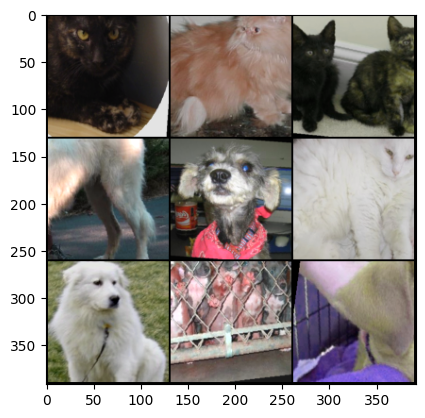

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
images, labels = next(iter(train_loader))

# Display some sample images
grid = torchvision.utils.make_grid(images[:9], nrow=3, padding=2, normalize=True)
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
plt.imshow(grid.permute(1,2,0))

In [10]:

class TinyVGG(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(TinyVGG, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 128x128 -> 64x64
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64 -> 32x32
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 -> 16x16
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.classifier(x)

In [ ]:
model = TinyVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        factor=0.5, patience=2)

In [12]:
# Reset model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [13]:
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

In [14]:

for epoch in range(num_epochs):
    # ----- Training -----
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total

    # ----- Evaluation -----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()


    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    
    # Save training losses and accuracy for plotting later
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Save model if the accuracy is better than previous epoch
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'val_accuracy': val_accuracy
                    }, "weights_tinyvgg.pth")
        print(
            f"[Info] saved new checkpoint with val accuracy: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(
        f"  Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  Val   Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 56.23%
Epoch 1/20
  Train Loss: 0.6903, Accuracy: 53.09%
  Val   Loss: 0.6663, Accuracy: 56.23%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 68.17%
Epoch 2/20
  Train Loss: 0.6469, Accuracy: 62.33%
  Val   Loss: 0.6014, Accuracy: 68.17%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 74.45%
Epoch 3/20
  Train Loss: 0.5778, Accuracy: 70.27%
  Val   Loss: 0.5164, Accuracy: 74.45%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 77.92%
Epoch 4/20
  Train Loss: 0.5253, Accuracy: 73.62%
  Val   Loss: 0.4552, Accuracy: 77.92%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 78.58%
Epoch 5/20
  Train Loss: 0.4871, Accuracy: 76.70%
  Val   Loss: 0.4478, Accuracy: 78.58%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 79.28%
Epoch 6/20
  Train Loss: 0.4441, Accuracy: 79.00%
  Val   Loss: 0.4385, Accuracy: 79.28%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 84.78%
Epoch 7/20
  Train Loss: 0.3910, Accuracy: 82.29%
  Val   Loss: 0.3410, Accuracy: 84.78%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 86.08%
Epoch 8/20
  Train Loss: 0.3606, Accuracy: 83.75%
  Val   Loss: 0.3155, Accuracy: 86.08%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 86.34%
Epoch 9/20
  Train Loss: 0.3269, Accuracy: 85.55%
  Val   Loss: 0.3216, Accuracy: 86.34%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 88.60%
Epoch 10/20
  Train Loss: 0.3053, Accuracy: 86.50%
  Val   Loss: 0.2683, Accuracy: 88.60%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 89.44%
Epoch 11/20
  Train Loss: 0.2903, Accuracy: 87.31%
  Val   Loss: 0.2455, Accuracy: 89.44%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 89.84%
Epoch 12/20
  Train Loss: 0.2747, Accuracy: 88.08%
  Val   Loss: 0.2356, Accuracy: 89.84%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 13/20
  Train Loss: 0.2613, Accuracy: 88.66%
  Val   Loss: 0.2496, Accuracy: 89.60%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 90.64%
Epoch 14/20
  Train Loss: 0.2503, Accuracy: 89.28%
  Val   Loss: 0.2237, Accuracy: 90.64%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 15/20
  Train Loss: 0.2335, Accuracy: 89.95%
  Val   Loss: 0.2328, Accuracy: 90.12%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 16/20
  Train Loss: 0.2383, Accuracy: 89.97%
  Val   Loss: 0.2061, Accuracy: 90.54%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 17/20
  Train Loss: 0.2230, Accuracy: 90.41%
  Val   Loss: 0.2293, Accuracy: 90.14%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 92.70%
Epoch 18/20
  Train Loss: 0.2188, Accuracy: 90.53%
  Val   Loss: 0.1772, Accuracy: 92.70%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 19/20
  Train Loss: 0.2136, Accuracy: 90.85%
  Val   Loss: 0.2095, Accuracy: 90.82%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 20/20
  Train Loss: 0.2128, Accuracy: 90.94%
  Val   Loss: 0.1789, Accuracy: 92.46%


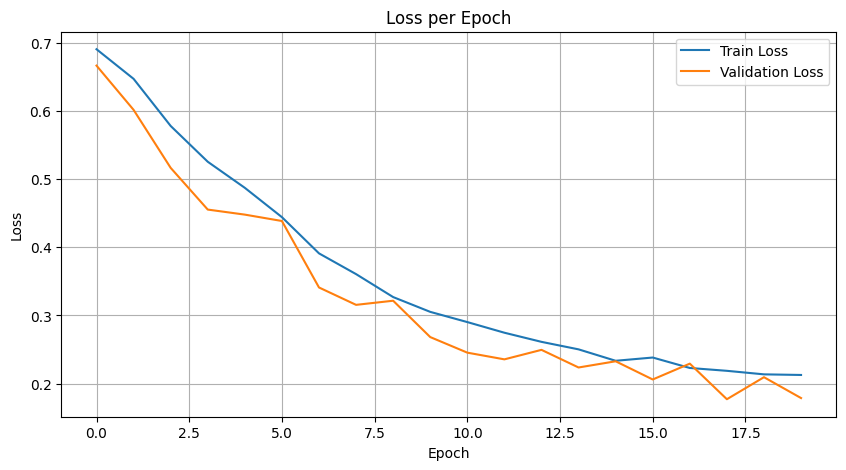

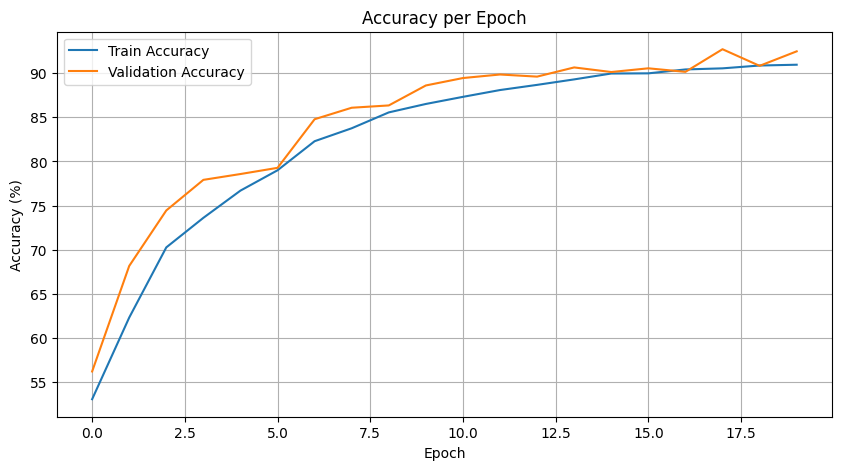

In [15]:
# Accuracy and losses graphs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()